在 [60分钟闪电战](https://github.com/benrenzhu/learn-PyTorch/blob/master/learn%20pytorch.ipynb)教程里，我们学会了如何载入数据，以及把数据应用到定义为 `nn.Moduel` 的子类构成的模型中。  

为了了解详细的过程，我们在训练模型时打印出一些统计数据，以便了解训练的进展。  
现在有更好的方法了: PyTorch 与 TensorBoard 集成，后者是一个用于可视化神经网络训练运行结果的工具。本教程说明了它的一部分功能，使用 [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) 数据集，可以通过 *torchvision.datasets* 读入 PyTorch。  

在这个教程中，我们将学会：  
1. 读入数据并做适当的格式转换（跟前面的教程大致相同）  
2. 设置 TensorBoard  
3. 编写 TensorBoard  
4. 使用 TensorBoard 检查模型架构  
5. 使用 TensorBoard 用更少的代码创建上一个教程中可视化的交互式版本  

特别的，在第五部分我们可以看到：  
- 检察训练数据的几种方法  
- 如何在训练过程中追踪模型的性能  
- 如何在训练结束后评估模型性能  

我们从 [CIFAR-10](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) 教程中类似的代码样板为例：

In [1]:
# 导入需要的模块  
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 格式转换
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))]
)

# 数据集
trainset = torchvision.datasets.FashionMNIST('./data',
                                            download=True,
                                            train=True,
                                            transform=transform)
testset = torchvision.datasets.FashionMNIST('./data',
                                           download=True,
                                           train=False,
                                           transform=transform)

# 载入数据
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

# 数据集包含的类别
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# 辅助函数
# 会在'plot_classes_preds'函数中用到
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5  # 逆归一化
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap='Greys')
    else:
        plt.imshow(np.transpose(npimg, (1,2,0)))

我们将从该教程中定义一个类似的模型架构，只做一些小的修改。考虑到输入图像的尺寸是单通道 28x28，而不是 3 通道（RGB）32x32:

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

定义 `optimizer` 和 `criterion` 分别作为优化器和损失函数

In [3]:
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

## 1. 设置 TensorBoard  

现在我们来设置 TensorBoard，从 `torch.utils` 导入 `TensorBoard`，然后定义 `SummaryWriter`，这是向 TensorBoard 写入信息的关键对象。

In [4]:
from torch.utils.tensorboard import SummaryWriter

# 默认的 'log_dir' 路径是 'runs'，我们需要明确一下具体的路径
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

注意，这行代码会在当前目录创建一个叫 `runs/fashion_mnist_experiment_1` 的文件夹

## 2. 写入 TensorBoard  

现在我们往 TensorBoard 中写入一个图像，具体地说，是写入一个 [make_grid](https://pytorch.org/docs/stable/torchvision/utils.html#torchvision.utils.make_grid) 的网格中。

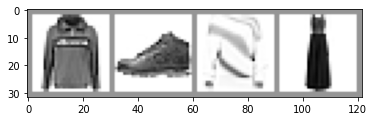

In [5]:
# 随机获取一些训练用的图像
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 创建图像网格
img_grid = torchvision.utils.make_grid(images)

# 预览图像
matplotlib_imshow(img_grid, one_channel=True)

# 写入 TensorBoard
writer.add_image('four_fashion_mnist_images', img_grid)

在当前路径打开终端，运行`tensorboard --logdir=runs`，启动 TensorBoard，打开浏览器，打开[https://localhost:6006](https://localhost:6006) ，界面如下：  
![4-1.png](./4-1.png)

现在你知道如何使用 TensorBoard 了！这个例子还可以在 Jupyter Notebook 中完成 -- 这种交互式可视化环境跟 TensorBoard 最搭。我们将在下面介绍其中一个用法，在教程结束时再多介绍几个。

## 3. 使用 TensorBoard 检查模型  

TensorBoard 的优势之一就是它拥有可视化复杂模型结构的能力。

In [6]:
writer.add_graph(net, images)
writer.close()

现在刷新 TensorBoard，你会看到一个“GRAPHS”标签，如下所示:  

![4-2.png](./4-2.png)  

双击“NET”来展开，可以看到组成模型的各个操作的详细视图。  
TensorBoard 有一个非常方便的特性——可以将高维数据可视化，比如在低维空间中的图像数据; 我们将在下一节讨论这个问题。

## 4. 给 TensorBoard 添加一个“Projector”  

通过 [`add_embedding`](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_embedding) 方法，我们可以直观地看到高维数据的低维表示  
 > add_embeddings [中文详解](https://www.freesion.com/article/4568905546/)

In [7]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
# 辅助函数
def select_n_random(data, labels, n=100):
    '''
    从数据集中随机选取 n 对数据和标签
    '''
    assert len(data) == len(labels)
    
    perm = torch.randperm(len(data))  # 返回一个0到n-1的一维张量
    return data[perm][:n], labels[perm][:n]

# 随机选择图像及其标签
images, labels = select_n_random(trainset.data, trainset.targets)

# 获取每张图像的标签
class_labels = [classes[lab] for lab in labels]

# 记录嵌入
features = images.view(-1, 28 * 28)

# mat (torch.Tensor or numpy.array): 一个矩阵，每行代表特征空间的一个数据点（features:二维tensor，每行代表一张照片的特征，其实就是把一张图片的28*28个像素拉平，一张图片就产生了784个特征）
# metadata (list or torch.Tensor or numpy.array, optional): 一个一维列表，mat 中每行数据的 label，大小应和 mat 行数相同（metadata:一维列表，代表每张图片的类别，图中不同颜色代表着不同类别） 
# label_img (torch.Tensor, optional): 一个形如 NxCxHxW 的张量，对应 mat 每一行数据显示出的图像，N 应和 mat 行数相同
writer.add_embedding(mat=features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.close()

在 TensorBoard 的“Projector”标签中，你可以看到这100张784维的照片被投射到三维空间中。而且是交互式的—— 你可以点击或拖动来旋转三维投影。  
为了使可视化更容易看到，这里有几个技巧: 在左上角选择“Color by：label”，以及启用“night mode”，黑色背景会让图像会更容易看清:  

![4-3.png](./4-3.png)

现在我们已经彻底检查了我们的数据，接下来看看 TensorBoard 如何使跟踪模型的训练和评估更加清晰。  
从训练开始：

## 5. 通过 TensorBoard 追踪模型的训练过程  

在前面的例子中，我们只是简单地打印了每2000次迭代的模型的损失（loss）。  
现在，我们将把损失记录到 TensorBoard 中，并通过 `plot_classes_preds` 函数对模型进行预测。

In [8]:
# 辅助函数  
def images_to_probs(net, images):
    '''
    根据训练好的网络和图像列表生成预测和相应的概率
    '''
    output = net(images)
    # 将输出的概率转换为预测类别
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

def plot_classes_preds(net, images, labels):
    '''
    使用经过训练的网络、来自批处理的图片和标签生成 matplotlib 图像，
    它显示了网络的排名前几位的预测值及其概率，
    与实际的标签一起，根据预测是否正确来给这些信息着色。
    使用“images_to_probs”函数。
    '''
    preds, probs = images_to_probs(net, images)
    # 把这批图像连同预测的和真实的标签一起绘制出来
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}， {1:.1f}%\n(label: {2})".format(
        classes[preds[idx]],
        probs[idx] * 100.0,
        classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

最后，让我们使用前面教程中相同的代码来训练模型，但是每1000个批次将结果写入 TensorBoard，而不打印到控制台; 我们可以用 `add_scalar` 函数完实现。  

另外，在训练过程中，我们将生成一张图片，展示模型对这一批四幅图片的预测值和真实值的对比。

In [9]:
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

running_loss = 0.0
for epoch in range(1):  # 多次循环数据集
    for i, data in enumerate(trainloader, 0):
        # 获得输入; 数据集是一个[输入，标签]的列表
        inputs, labels = data
        
        # 把参数的梯度归零
        optimizer.zero_grad()
        
        # 向前、向后传播，优化
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 1000 == 999:
            # 记录损失
            writer.add_scalar('training_loss',
                             running_loss / 1000,
                             epoch * len(trainloader) + i)
            
            # 记录一个 Matplotlib 图像来显示模型在随机批次上的预测
            writer.add_figure('预测 vs. 真实',
                             plot_classes_preds(net, inputs, labels),
                             global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
    print('训练结束')

训练结束


> 注，如果遇到“matplotlib Glyph xxxxx missing from current font”的解决方案：  
    ```python  
    import matplotlib    
    print(matplotlib.matplotlib_fname())
    ```  
    修改matplotlibrc文件，文件位置在上述 print 出来的地址。修改内容：      
    去掉前面的#  
    font.family         : sans-serif   
    去掉前面的#  
    font.sans-serif     : Bitstream Vera Sans, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif  
    去掉前面的#，并将True改为False  
    axes.unicode_minus  : False         
    

你现在可以查看"SCALARS"标签，看看在15000次迭代训练过程中的损失情况:  
![4-4.png](./4-4.png)  

此外，我们可以看到在整个学习过程中，模型对任意批次做出的预测。查看“ Images”选项卡，并往下滚动，查看“ 预测 vs. 真实”可视化; 可视化展示了，比如说经过3000次训练迭代，即使它不如在后来的训练中置信度那么高，模型已然能够在视觉上区分不同的类别，如衬衫、运动鞋和外套:  
![4-5.png](./4-5.png) 


## 6. 通过 TensorBoard 评估训练好的模型  

In [10]:
# 1. 获取测试集大小 乘 种类数量的张量中概率的预测
# 2. 获取 test_size 数目 preds 的 张量

class_probs = []
class_preds = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        _, class_preds_batch = torch.max(output, 1)
        
        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)
        
test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

# 辅助函数
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    接受从0到9的“class_index”并绘制相应的精度-召回曲线
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]
    
    writer.add_pr_curve(classes[class_index],
                       tensorboard_preds,
                       tensorboard_probs,
                       global_step=global_step)
    writer.close()
    
# 绘制所有的精度-召回曲线
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)

现在可以看到一个“PR Curves”选项卡，其中包含每个类的精度-查全率曲线。你会看到在一些种类中，模型几乎有100%的“曲线下面积”，而在其他中类中这个面积却更低:
![4-6.png](./4-6.png)  

这是对 TensorBoard 和 PyTorch 集成的入门。TensorBoard 能做的 Jupyter Notebook 都能做，但是在 TensorBoard 中，你可以直接得到交互式的可视化效果。